<img src="../../thu_sigs_logo.png" alt="清华深研院-横" style="zoom:50%;" />

In [1]:
#| hide
#| default_exp adaboost.vis
# pdf:
#   toc: true
#   docx: default

In [ ]:
#|hide
from thu_big_data_ml.help import plt

In [ ]:
#|hide
%load_ext autoreload
%autoreload 2

::: {.callout-important}
本文档具有一定的交互性，建议使用浏览器打开html文件，这样比pdf文件阅读体验更佳。
:::

## 第一题——一个例子理解 AdaBoost {#sec-1}
题目如下

> 某公司招聘职员考查身体、业务能力、发展潜力这3项。身体分为合格1、不合格0两级，业务能力和发展潜力分为上1、中2、下3三级。分类为合格1、不合格-1两类。
> 
> 已知10个人的数据，如表格1所示。假设弱分类器为决策树桩。试用AdaBoost算法学习一个强分类器。


表1：应聘人员情况数据表

| 列 | 1  | 2  | 3  | 4  | 5  | 6  | 7  | 8  | 9  | 10 |
|---|----|----|----|----|----|----|----|----|----|----|
| 身体 | 0  | 0  | 1  | 1  | 1  | 0  | 1  | 1  | 1  | 0  |
| 业务能力 | 1  | 3  | 2  | 1  | 2  | 1  | 1  | 1  | 3  | 2  |
| 发展潜力 | 3  | 1  | 2  | 3  | 3  | 2  | 2  | 1  | 1  | 1  |
| 分类  | -1 | -1 | -1 | -1 | -1 | -1 | 1  | 1  | -1 | -1 |


### 审题 {#sec-1-analysis}

我们首先复习一下李航书上的内容。

- 什么是 Boosting？
    - 李航书上boost是提升的意思,指的是把一个弱学习算法提升为强学习算法。因为PAC框架下被证明,如果前者存在,后者必定存在,反之亦然。
    - 我们如果已经找到弱学习算法，那当然是说明强学习算法存在，但是找到强学习算法的算法未必存在，但是我们可以尝试构造。
    - 强就是准确率高，具体多高书上没定义，弱就是比随机猜测（最大熵模型？）好。
    - 注意学习算法不是学习器，弱学习算法是说，多项式时间内训练出一个弱学习器的算法。boost操作的对象是“弱学习算法”，那个多项式时间复杂度的算法，不一定是通过操作弱学习器，当然如果你的boost只需要操作弱学习器，构造出强学习器，这个步骤本身构成了强学习算法，那这个当然也是boost。
    - ？难道其他ensemble learning算法不是把弱学习提升为强学习吗
    - 李航书上说“大多数的boosting方法”是改变训练数据的概率分布来解决提升的问题。这个或许就是和其他集成学习的区别。


    
- 什么是 AdaBoost 算法？    
    - 多轮学习多个弱学习分类器，每一轮的数据概率分布有所不同，依赖于上一轮的结果。
    - 上一轮若分类器错误分类的样本权值变大，正确的权值变小，权值加起来始终为1, 变化规则是 $w_{m+1, i} = w_{mi} \frac{1}{Z_m} exp(-\alpha_m y_i G_m(x_i))$，其中$y_i \in \{1, -1\}$
    - 集成分类器 $G(x) = sign(\sum_{m=1}^{M}\alpha_m G_m(x)) $, 注意 $\alpha_m$ 加在一起并不是1。这个很奇怪？
    - 其中 $\alpha_m = \frac{1}{2} log\frac{1-e_m}{e_m}$, 而$e_m$是按照 $w_m$加权后$G_m$的错误率，$\alpha_m$ 像是 分类器加权正确率的logodds的一半。不知道为什么这样设计？

- AdaBoost 的第二解释如何理解？
    - 李航书上给出了8.3节，认为 AdaBoost 也是加法模型在指数函数下使用前向分步算法进行二分类的学习方法。

    <!-- TODO -->


- 什么是决策树桩？
    - 李航统计学习方法166页给出了这个概念。
    - 决策树桩（Decision Stump）是就是只有一个分裂节点和两个叶节点的决策树，也就是只有单个特征（假如是连续型随机变量），根据阈值分割为两个集合，然后集合内哪个类别多就是哪个。
    - 在二分类的情况下，使用决策树桩作为基本分类器的 AdaBoost 又叫做boosting tree提升树算法。多分类和回归的话提升树就有一些新的方法。

- 什么是概率近似正确框架？


复习之后，我们来看看题目询问的问题。

首先对 表格 可视化

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# 创建原始数据的np array
data = np.array([
    [0, 1, 3, -1],
    [0, 3, 1, -1],
    [1, 2, 2, -1],
    [1, 1, 3, -1],
    [1, 2, 3, -1],
    [0, 1, 2, -1],
    [1, 1, 2, 1],
    [1, 1, 1, 1],
    [1, 3, 1, -1],
    [0, 2, 1, -1]
])

# 将np array转换为DataFrame
df = pd.DataFrame(data, columns=['身体', '业务能力', '发展潜力', '分类'])

df

,身体,业务能力,发展潜力,分类
0,0,1,3,-1
1,0,3,1,-1
2,1,2,2,-1
3,1,1,3,-1
4,1,2,3,-1
5,0,1,2,-1
6,1,1,2,1
7,1,1,1,1
8,1,3,1,-1
9,0,2,1,-1


In [ ]:
#| export
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
#| export
# 创建图表，
# 需要有网格线，
# 需要有文本标注点的名字和坐标
# 坐标轴名称和正负例的图例要和李航书的一样
# 正负例的形状不同（黑白打印的审稿人），颜色不同

def plot_binary_classification_3d(X, y, labels=[1, -1], label_names=['正例', '负例'],
                                  label_colors=['blue', 'red'],
                                  label_markers=['o', 'x'], 
                                  x_names=['x(1)', 'x(2)', 'x(3)'], 
                                  point_size=100,
                                  text_offset=(0.1, 0.1, 0.1), 
                                  point_names=None, 
                                  title='数据点可视化', 
                                  size=(9, 6), 
                                  ):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    if point_names is None:
        point_names = [f'x{i+1}' for i in range(len(X))]

    # 绘制正例和负例，并标注点名和坐标
    label_has_drawn = set()
    for i, (x, label) in enumerate(zip(X, y)):
        
        label_idx = labels.index(label)
        if label_idx in label_has_drawn:
            label_name = ''
        else:
            label_has_drawn.add(label_idx)
            label_name = label_names[label_idx]
        
        ax.scatter(x[0], x[1], x[2], color=label_colors[label_idx], marker=label_markers[label_idx], 
                   label=label_name, 
                   s=point_size)
        ax.text(x[0] + text_offset[0], x[1] + text_offset[1], x[2] + text_offset[2], f' {point_names[i]} ({x[0]}, {x[1]}, {x[2]})', fontsize=12, ha='left')

    # 添加网格线
    ax.grid(True)

    # 添加图例
    ax.legend()

    # 修改坐标轴名称
    ax.set_xlabel(x_names[0])
    ax.set_ylabel(x_names[1])
    ax.set_zlabel(x_names[2])
    ax.set_title(title)
    fig.set_size_inches(*size)
    
    ax.set_box_aspect((1,1,1))
    
    return fig, ax

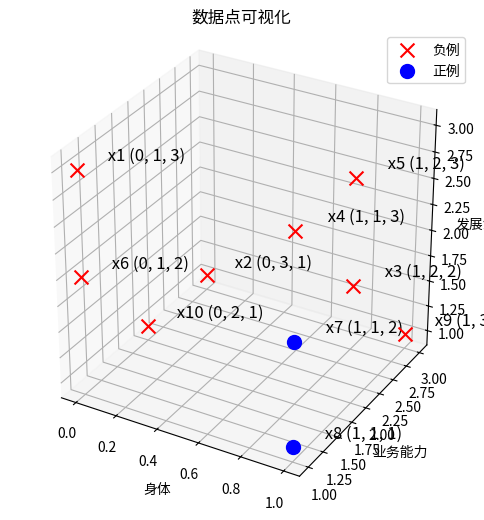

In [9]:
X_columns = ['身体', '业务能力', '发展潜力']
y_column = '分类'
X = df[X_columns].values
y = df[y_column].values
fig, ax = plot_binary_classification_3d(X, y,x_names=X_columns)
plt.show()


接下来尝试使用 AdaBoost算法

### 解题 {#sec-1-solution}



#### 解法一：手算推导法（考试写解答题）

初始化权值分布 $D_1 = (w_{1, 1}, w_{1, 2}, \cdots, w_{1, 10}) = (\frac{1}{10}, \frac{1}{10}, \cdots, \frac{1}{10})$

1. 首先我们在 $D_1$ 上学习决策树桩。决策树桩有很多种学习准则，比较常用的 AdaBoost-SAMME 方法选择的是 CART 决策树的分类树,[参考](https://scikit-learn.org/dev/modules/ensemble.html#adaboost)，也就是用 gini 系数来做特征选择，同时选择最优二值切分点。

首先计算“身体”这个属性的基尼指数。

 $$Gini(D_1, 身体=0 or not) = \frac{4}{10}(1- (1^2 + 0^2)) + \frac{6}{10}( 1- (\frac{4}{6}^2 + \frac{2}{6}^2)) = \frac{4}{15}$$
 
 ， 最优切分点是“是否 身体=0”，因为没有别的选择。

 注意这里 李航书上的表示是具有误导性的，李航书上写的  $Gini(D_1, 身体=0)$ 表示的是 身体=0这个子集上的基尼指数，而我们这里是在说 身体==0 这个特征，严谨的表述是 $Gini(D_1, 身体==0)$
 <!-- 因为0更小最优切分点是“是否 身体=0”，当然这里只有两个取值，所以不用选，算基尼指数是为了和别的属性比较。 -->

同理可得
$$Gini(D_1, 业务能力==1), Gini(D_1, 业务能力==2),Gini(D_1, 业务能力==3)$$

$$Gini(D_1, 发展潜力==1), Gini(D_1, 发展潜力==2), Gini(D_1, 发展潜力==3)$$

由于 Gini(D_1, 业务能力==1) 最小，

$$
G_1 = 
\begin{cases}
1, & \text{如果 } 业务能力==1; \\
-1, & \text{如果 } 业务能力!=1 .
\end{cases}
$$

注意这里是不平衡二分类，所以我们对CART做了调整，要不然两个树桩都是-1.


In [10]:
#| export
def calculate_gini_index_for_subset(df_subset):
    """
    计算给定 DataFrame 子集的 Gini 指数。
    
    参数:
    df_subset (pd.DataFrame): 包含类别标签的 DataFrame 子集。
    
    返回:
    float: Gini 指数。
    """
    # 获取类别标签的频率
    class_counts = df_subset.iloc[:, -1].value_counts()
    total_instances = len(df_subset)
    
    # 计算 Gini 指数
    gini_index = 1.0 - sum((count / total_instances) ** 2 for count in class_counts)
    
    return gini_index

def calculate_gini_index(df, feature, value):
    # 提取特征等于特定值的数据子集
    equal_set = df[df[feature] == value]
    ne_set = df[df[feature] != value]
    
    equal_ratio = len(equal_set) / len(df)
    ne_ratio = len(ne_set) / len(df)
    
    equal_set_gini_index = calculate_gini_index_for_subset(equal_set)
    ne_set_gini_index = calculate_gini_index_for_subset(ne_set)
    
    return (equal_ratio * equal_set_gini_index) + (ne_ratio * ne_set_gini_index)
    
    

In [11]:
gini_body_0 = calculate_gini_index(df, '身体', 0)
gini_yewu_1 = calculate_gini_index(df, '业务能力', 1)
gini_yewu_2 = calculate_gini_index(df, '业务能力', 2)
gini_yewu_3 = calculate_gini_index(df, '业务能力', 3)
gini_fazhan_1 = calculate_gini_index(df, '发展潜力', 1)
gini_fazhan_2 = calculate_gini_index(df, '发展潜力', 2)
gini_fazhan_3 = calculate_gini_index(df, '发展潜力', 3)

gini_body_0, gini_yewu_1, gini_yewu_2, gini_yewu_3, gini_fazhan_1, gini_fazhan_2, gini_fazhan_3

(0.26666666666666666,
 0.24,
 0.2857142857142857,
 0.30000000000000004,
 0.31666666666666665,
 0.3047619047619048,
 0.2857142857142857)


2. 训练数据集上的分类误差率是 $e_1 = P(G_1(x_i) \ne y_i) = 0.3$ , 因为样本 1,4,6 都分错了

3. $G_1(x)$ 的 系数 \alpha_1 = \frac{1}{2} \log (\frac｛ 1-0.3 ｝｛ 0.3 ｝)

更新 $D_2$, 分类错误的1, 4, 6 权重提升为 0.16667,  其他样本分类正确，降低为 0.07143


In [13]:
e = 0.3
alpha = 0.5 * np.log((1 - e) / e)
alpha

0.42364893019360184

同理我们可以在 $D_2$ 上学习决策树桩。
三轮之后，我们可以得到分类正确率 100% 的集成模型。

#### 解法二：使用Python和机器学习库（科研使用）

参考 https://scikit-learn.org/dev/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
import numpy as np

In [ ]:
clf = AdaBoostClassifier(n_estimators=3)
clf.fit(X, y)
y_predict = clf.predict(X)
score = clf.score(X, y)
score

/home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


1.0

In [20]:
clf.estimators_

[DecisionTreeClassifier(max_depth=1, random_state=1986558224),
 DecisionTreeClassifier(max_depth=1, random_state=209715172),
 DecisionTreeClassifier(max_depth=1, random_state=1797073605)]

In [21]:
clf.estimator_errors_

array([2.00000000e-01, 1.66666673e-01, 2.25517146e-08])

In [22]:
clf.estimator_weights_

array([1., 1., 1.])

注意第一轮的弱分类器因为数据不平衡，所以选择所有样本的都是1，所以分类误差率是0.2, 而不是我们的0.3

## 第二题——理解AdaBoost和其他方法的关系 {#sec-2}

题目如下
> 比较支持向量机、AdaBoost、逻辑斯谛回归模型的学习策略与算法。


### 解题 {#sec-2-solution}


| 特性       | 支持向量机 (SVM) | AdaBoost | AdaBoost第二种理解 | 逻辑斯谛回归模型 |
|------------|----------------|---------|------------------|------------------|
| 模型       | w和b表示的分割超平面 | 弱学习器组合成的强学习器 | (弱学习器作为基函数提取的特征的)加法模型 | w和b表示的分割超平面 |
| 学习策略（训练损失） | 间隔最大化      | 关注错误样本 | 最小化指数损失 | 最大化似然函数   |
| 参数学习算法   | 原始问题梯度下降、对偶问题凸二次规划、SMO算法等 | 多轮迭代改变样本概率分布，学习多个弱分类器，根据错误率组合弱分类器为强分类器 | 前向分步算法   | 梯度下降、拟牛顿法等   |
| 优缺点     | 泛化能力强，对参数敏感 | 减小偏差，对异常值敏感 | 同左列 | 效率高，非线性表现不佳 |

我们可以画出一个思维导图

```{mermaid}
graph LR
    A[Machine Learning Algorithms] --> B[Support Vector Machine SVM]
    A --> C[AdaBoost]
    A --> E[Logistic Regression Model]
    
    B -->|Model| B1[Separating Hyperplane w and b]
    B -->|Learning Strategy Training Loss| B2[Margin Maximization]
    B -->|Parameter Learning Algorithm| B3[Gradient Descent for Primal Problem, Convex Quadratic Programming for Dual Problem, SMO Algorithm, etc.]
    B -->|Advantages and Disadvantages| B4[Strong Generalization, Sensitive to Parameters]
    
    C -->|Model| C1[Combination of Weak Learners into a Strong Learner]
    C -->|Learning Strategy Training Loss| C2[Focus on Misclassified Samples]
    C -->|Parameter Learning Algorithm| C3[Multiple Iterations to Change Sample Probability Distribution, Learning Multiple Weak Classifiers, Combining Weak Classifiers into a Strong Classifier Based on Error Rate]
    C -->|Advantages and Disadvantages| C4[Reduces Bias, Sensitive to Outliers]
    
    E -->|Model| E1[Separating Hyperplane w and b]
    E -->|Learning Strategy Training Loss| E2[Minimization of Exponential Loss]
    E -->|Parameter Learning Algorithm| E3[Gradient Descent, Quasi-Newton Methods, etc.]
    E -->|Advantages and Disadvantages| E4[High Efficiency, Poor Performance on Non-linear Problems]


```

### 题目扩展问题





In [10]:
#| hide
import nbdev; nbdev.nbdev_export()